In [45]:
#import packages
#feel free to import more if you need
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

In [46]:

#evaluate the benign accuracy of a model
def test(model, x,y,batch_size):
    model.eval()
    total=x.shape[0]
    batches=np.ceil(total/batch_size).astype(int)
    success=0
    loss=0
    for i in range(batches):
        start_index=i*batch_size
        end_index=np.minimum((i+1)*batch_size,total)
        x_batch=torch.tensor(x[start_index:end_index]).float()
        y_batch=torch.tensor(y[start_index:end_index]).long()
        output=model(x_batch)
        pred=torch.argmax(output,dim=1)
        loss+=F.cross_entropy(output,y_batch).item()
        success+=(pred==y_batch).sum().item()
    print ("accuracy: "+str(success/total))
    return success/total


In [47]:
#define model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x=self.conv1(x)
        x=F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [49]:
# from recitation
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
norm = Normalize(mean=[0.485], std=[0.229]) # for one channel

In [50]:
#load MNIST
dataset_train = datasets.MNIST('../data', train=True, download=True)
dataset_test = datasets.MNIST('../data', train=False, download=True)

# reshape MNIST
x_train=dataset_train.data.numpy()
y_train=dataset_train.targets.numpy()
x_test=dataset_test.data.numpy()
y_test=dataset_test.targets.numpy()
x_train=np.reshape(x_train,(60000,28,28,1))
x_test=np.reshape(x_test,(10000,28,28,1))
x_train=np.swapaxes(x_train, 1, 3)
x_test=np.swapaxes(x_test, 1, 3)

In [51]:
#REMINDER: the range of inputs is different from what we used in the recitation
print (x_test.min(),x_test.max())
print(x_test.shape)
print(y_test)

0 255
(10000, 1, 28, 28)
[7 2 1 ... 4 5 6]


In [52]:
modelA=Net()
modelA.load_state_dict(torch.load("modelA.zip"))
model_A_ref_acc = test(modelA,x_test,y_test,10000)
modelB=Net()
modelB.load_state_dict(torch.load("modelB.zip"))
model_B_ref_acc = test(modelB,x_test,y_test,10000)

accuracy: 0.9856
accuracy: 0.9839


In [31]:
def plot_success_rate(epsilon_list, acc_list, success_list, model='A', n_iter=None, alpha=None, attack=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].plot(epsilon_list, acc_list, label='Test Accuracy')
    ax[0].scatter(epsilon_list, acc_list, label='Test Accuracy', color= 'orange')
    ax[0].set_title('Test Accuracy wrt Epsilon')
    ax[0].set_xlabel('Epsilon')
    ax[0].set_ylabel('Test Accuracy')
   
    ax[1].plot(epsilon_list, success_list, label='Success Rate')
    ax[1].scatter(epsilon_list, success_list, label='Success Rate', color= 'orange')
    ax[1].set_title('Success Rate wrt Epsilon')
    ax[1].set_xlabel('Epsilon')
    ax[1].set_ylabel('Success Rate')
    
    
    if n_iter:
        fig.suptitle(f'({attack} Epsilon vs Success Rate,Test Accuracy for model:: {model}, niter: {n_iter}, alpha:  {alpha:.4f}')
        fig.savefig(f'success_rate_plot_{attack}_mod{model}_iter{n_iter}_a-{alpha:.4f}.png')
    else:
        fig.suptitle(f'{attack} Epsilon vs Success Rate,Test Accuracy for model: {model}')
        fig.savefig(f'success_rate_plot_{attack}_mod{model}.png')
    fig.tight_layout()

    plt.show()

In [11]:
def attack_plot(perturbed_images, test_images, index, name, epsilon, model='A', n_iter=None, alpha=None):
    fig, ax = plt.subplots(1, 2)
    perturbed_images = perturbed_images.squeeze().detach().numpy()
    test_images = test_images.squeeze()
    
    ax[0].imshow(test_images[index], cmap='gray')
    ax[0].set_title('Input Image')
    
    ax[1].imshow(perturbed_images[index], cmap='gray')
    ax[1].set_title('Perturbed Image')
    
    fig.tight_layout()
    if n_iter:
        fig.suptitle(f'{name} attack with epsilon {epsilon:.4f}, n_iter {n_iter}, alpha {alpha:.4f}')
        fig.savefig(f'{name}/{name}_attack__mod{model}_e-{epsilon:.4f}_a-{alpha:.4f}Img-{index}_iter{n_iter}.png')
    else:
        fig.suptitle(f'{name} attack with epsilon {epsilon:.4f}')
        fig.savefig(f'{name}/{name}_attack__mod{model}_{epsilon:.4f}_Img-{index}.png')
    plt.show()

In [12]:
#untargeted attack
def untargeted_attack(input, label, model, epsilon):
    x = input.detach().clone()
    x.requires_grad = True
    
    x_norm = norm(x) # normalize
    pred_old = model(x_norm)
    
    model.zero_grad()
    # print('pred old', pred_old.shape)
    # print('pred new',  label.shape)

    loss= nn.CrossEntropyLoss()(pred_old, label)
    loss.backward()
    gradient = x.grad
    # print(gradient.shape)
    with torch.no_grad():
        x = x + epsilon*gradient.sign()
        eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
        x = torch.clamp(input + eta, min=0, max=1).detach().clone()
        x = torch.round(x*255)/255
    pred_new = model(norm(x))
    return x, pred_new 

____________________________________________________________________
Model A
Epsilon: 0.02


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.1156
Success rate of the untargeted attack: 0.6395
Accuracy of the model on adversarial inputs: 0.1156
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8700


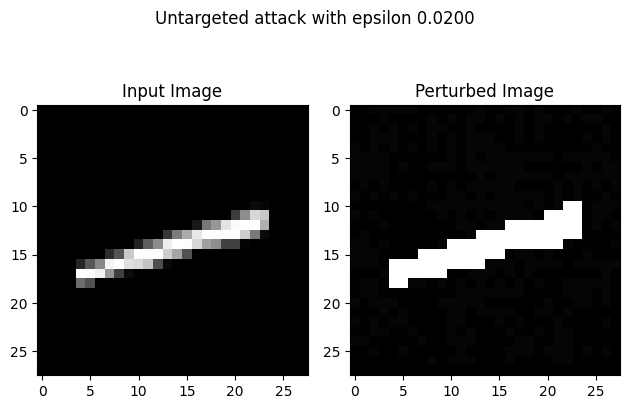

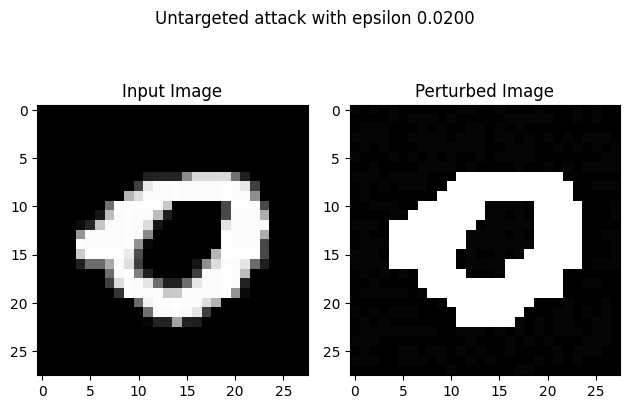

____________________________________________________________________
Model A
Epsilon: 0.05
accuracy: 0.109
Success rate of the untargeted attack: 0.6345
Accuracy of the model on adversarial inputs: 0.109
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8766


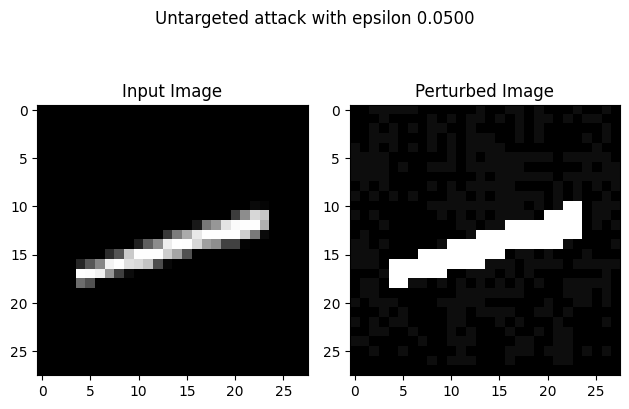

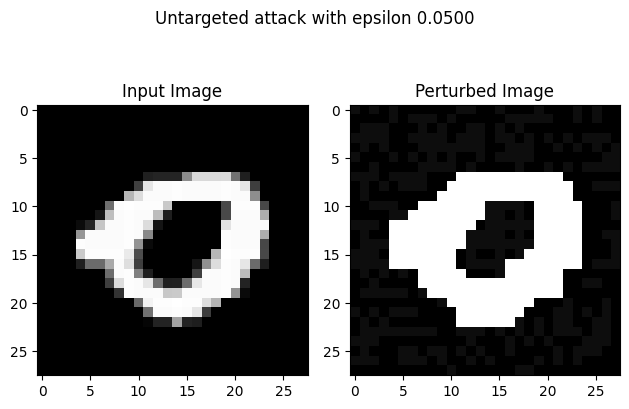

____________________________________________________________________
Model A
Epsilon: 0.1
accuracy: 0.1042
Success rate of the untargeted attack: 0.6235
Accuracy of the model on adversarial inputs: 0.1042
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8814


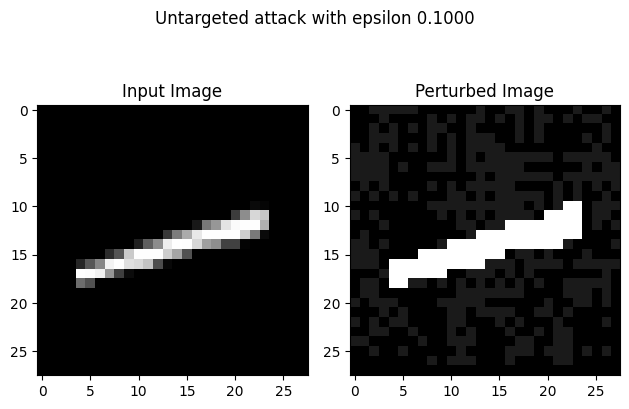

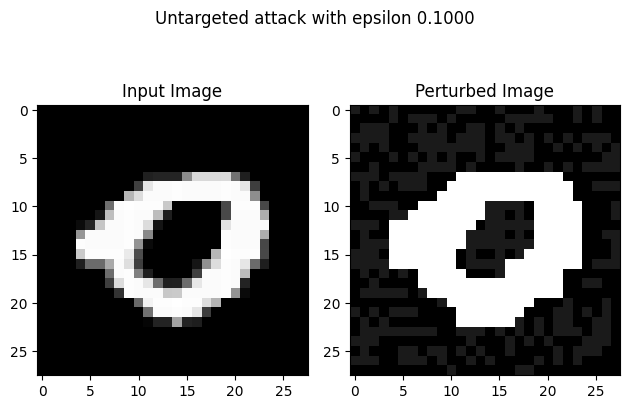

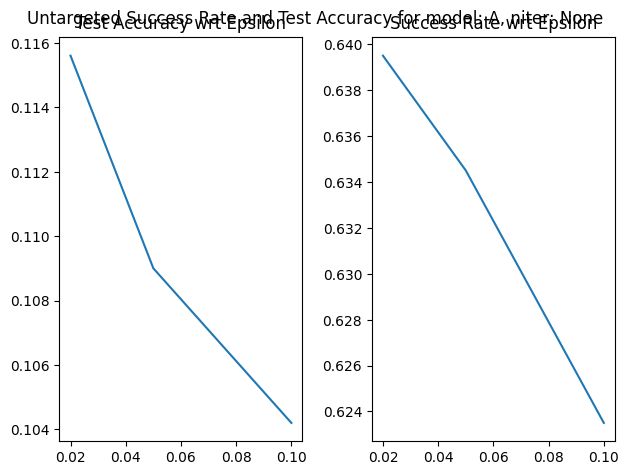

In [17]:
epsilon_list = [.02, .05, .1]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []

for epsilon in epsilon_list:
    adversarial_inputs = []
    pred_adv = []
    print('____________________________________________________________________')
    print('Model A')
    print('Epsilon:', epsilon)
    modelA.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        # print('input label', input_label.shape)
        x, pred = untargeted_attack(input_tensor, input_label, modelA, epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(x)

    pred_adv = torch.cat(pred_adv, dim=0)
    adversarial_inputs = torch.cat(adversarial_inputs, dim=0)
    success_rate = np.sum(torch.argmax(pred_adv, dim=1).numpy() != y_test) / len(y_test)
    adv_accuracy = test(modelA, adversarial_inputs, y_test, 10000)

    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [adv_accuracy]
    
    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {adv_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')
    print(f'Difference in accuracy: {model_A_ref_acc - adv_accuracy:.4f}')
    attack_plot(perturbed_images=adversarial_inputs, test_images=x_test, index=2, name='Untargeted', epsilon=epsilon, model = 'A')
    attack_plot(perturbed_images=adversarial_inputs, test_images=x_test, index=3, name='Untargeted', epsilon=epsilon, model = 'A')
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='A', attack='Untargeted')

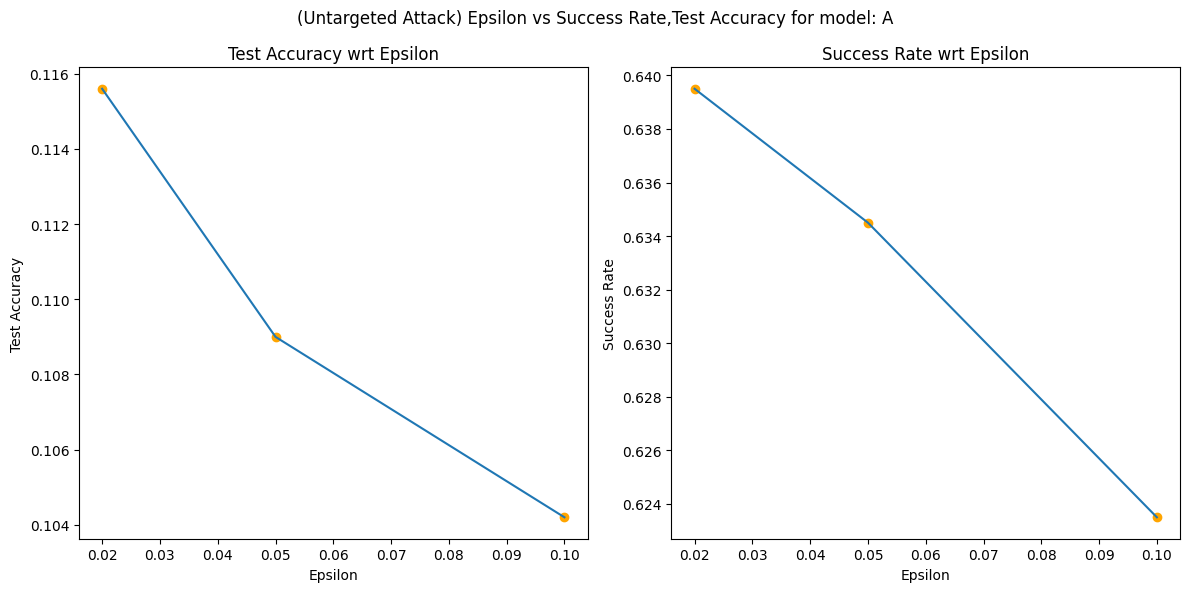

In [32]:
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='A', attack='(Untargeted Attack)')

____________________________________________________________________
ModelB
Epsilon: 0.02


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.1135
Success rate of the untargeted attack: 0.8865
Accuracy of the model on adversarial inputs: 0.1135
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8721


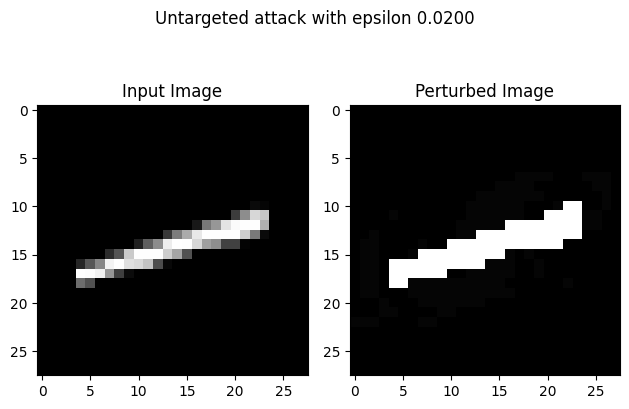

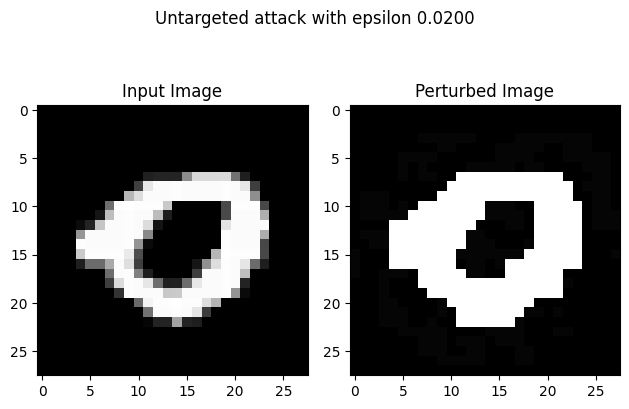

____________________________________________________________________
ModelB
Epsilon: 0.05
accuracy: 0.1135
Success rate of the untargeted attack: 0.8865
Accuracy of the model on adversarial inputs: 0.1135
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8721


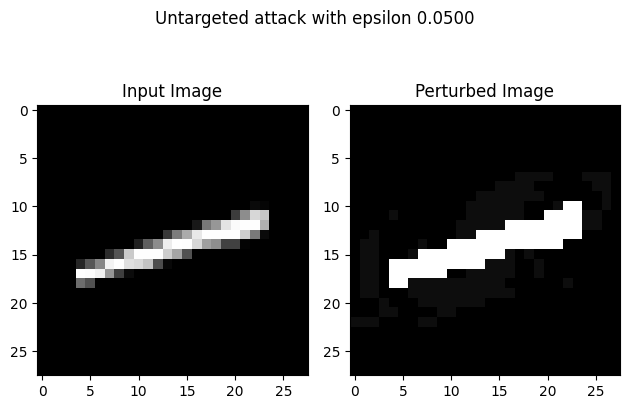

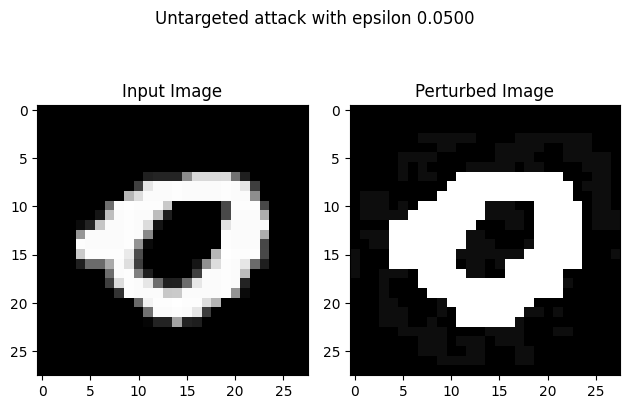

____________________________________________________________________
ModelB
Epsilon: 0.1
accuracy: 0.1135
Success rate of the untargeted attack: 0.8865
Accuracy of the model on adversarial inputs: 0.1135
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8721


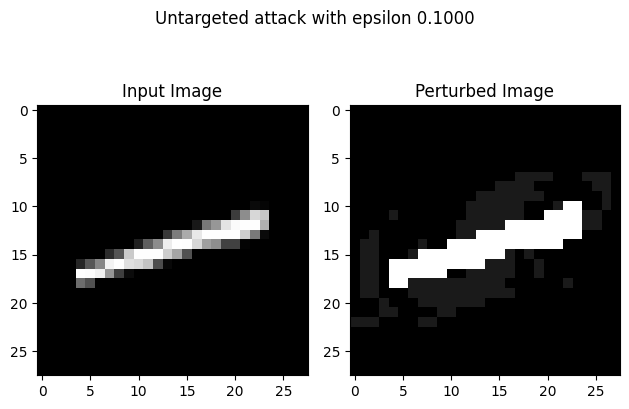

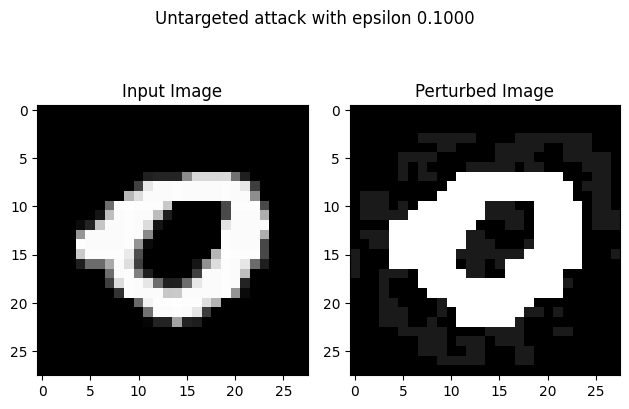

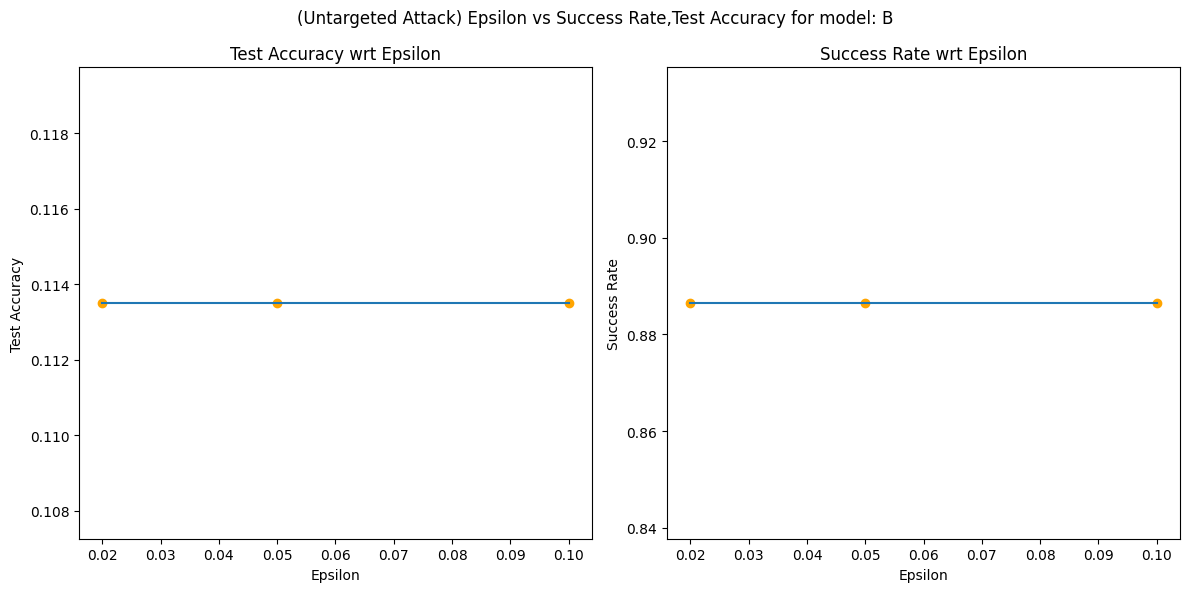

In [34]:
epsilon_list = [.02, .05, .1]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []


for epsilon in epsilon_list:
    adversarial_inputs = []
    pred_adv = []
    print('____________________________________________________________________')
    print('ModelB')
    print('Epsilon:', epsilon)
    modelB.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        # print('input label', input_label.shape)
        x, pred = untargeted_attack(input_tensor, input_label, modelB, epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(x)

    pred_adv = torch.cat(pred_adv, dim=0)
    adversarial_inputs = torch.cat(adversarial_inputs, dim=0)
    success_rate = np.sum(torch.argmax(pred_adv, dim=1).numpy() != y_test) / len(y_test)
    adv_accuracy = test(modelB, adversarial_inputs, y_test, 10000)
    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [adv_accuracy]
    
    
    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {adv_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')
    print(f'Difference in accuracy: {model_A_ref_acc - adv_accuracy:.4f}')
    attack_plot(perturbed_images=adversarial_inputs, test_images=x_test, index=2, name='Untargeted', epsilon=epsilon, model = 'B')
    attack_plot(perturbed_images=adversarial_inputs, test_images=x_test, index=3, name='Untargeted', epsilon=epsilon, model = 'B')
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='B', attack='(Untargeted Attack)')

# Targeted Attack

In [60]:
#load MNIST
dataset_train = datasets.MNIST('../data', train=True, download=True)
dataset_test = datasets.MNIST('../data', train=False, download=True)

# reshape MNIST
x_train=dataset_train.data.numpy()
y_train=dataset_train.targets.numpy()
x_test=dataset_test.data.numpy()
y_test=dataset_test.targets.numpy()
x_train=np.reshape(x_train,(60000,28,28,1))
x_test=np.reshape(x_test,(10000,28,28,1))
x_train=np.swapaxes(x_train, 1, 3)
x_test=np.swapaxes(x_test, 1, 3)

In [61]:
def targeted_attack_success(preds, y_test, class_to_attack=1, target_class=8):
    preds = np.array(preds)
    y_test = np.array(y_test)
    is_class_to_attack = (y_test == class_to_attack)
    correctly_attacked = (preds[is_class_to_attack] == target_class).sum()
    total_class_to_attack = is_class_to_attack.sum()
    if total_class_to_attack > 0:
        success_rate = correctly_attacked / total_class_to_attack 
    else:
        0
    return success_rate

In [62]:
# from recitation
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [63]:

def pgd_targeted_attack(input, label, model, target_class=8, class_to_attack=1, n_iter=100, alpha=1/255, epsilon=10/255):
    if label != class_to_attack:
        predictions = model(norm(input))
        return input, predictions
    else:
        x = input.detach().clone() 
        for i in range(n_iter):
            x.requires_grad = True
            predictions = model(norm(x))
            model.zero_grad()
            loss = nn.CrossEntropyLoss()(predictions, torch.LongTensor([target_class]))
            loss.backward()
            gradients = x.grad
            
            with torch.no_grad():
                x = x - alpha * gradients.sign()
                eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
                x = torch.clamp(input + eta, min=0, max=1)
                x = torch.round(x * 255) / 255 
            
    predictions = model(norm(x))
    return x, predictions

____________________________________________________________________
Model A, epsilon: 0.09803921568627451, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8726
Success rate of the attack: 0.04581497797356828
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


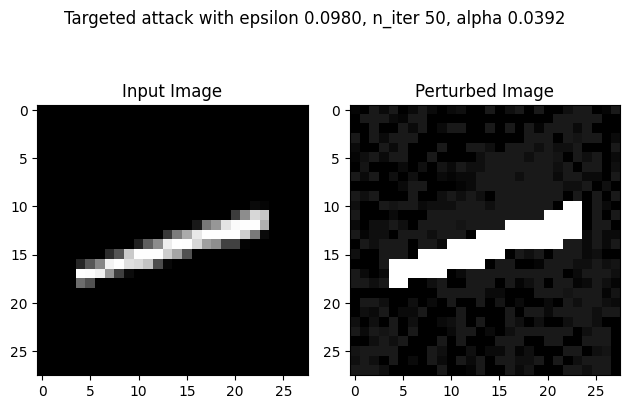

____________________________________________________________________
Model A, epsilon: 0.19607843137254902, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8726
Success rate of the attack: 0.5286343612334802
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


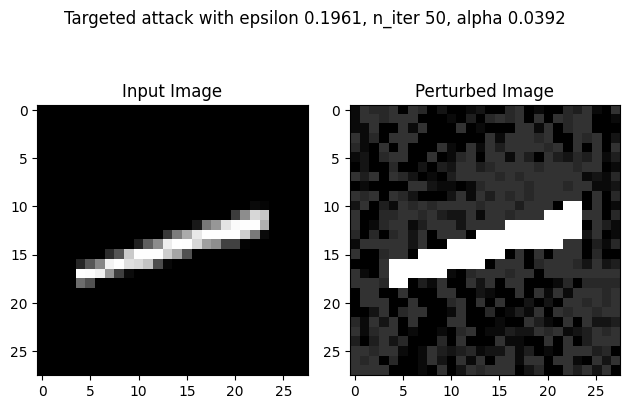

____________________________________________________________________
Model A, epsilon: 0.39215686274509803, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8726
Success rate of the attack: 1.0
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


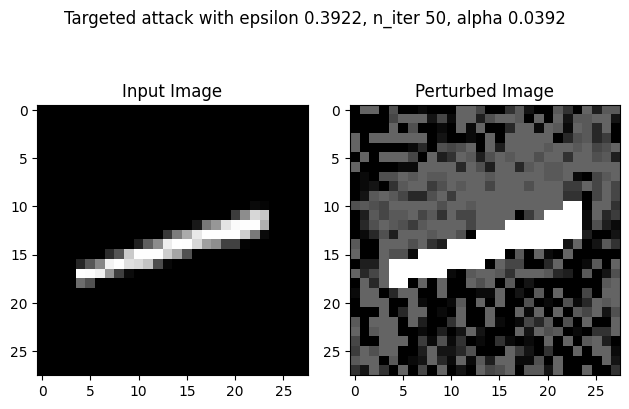

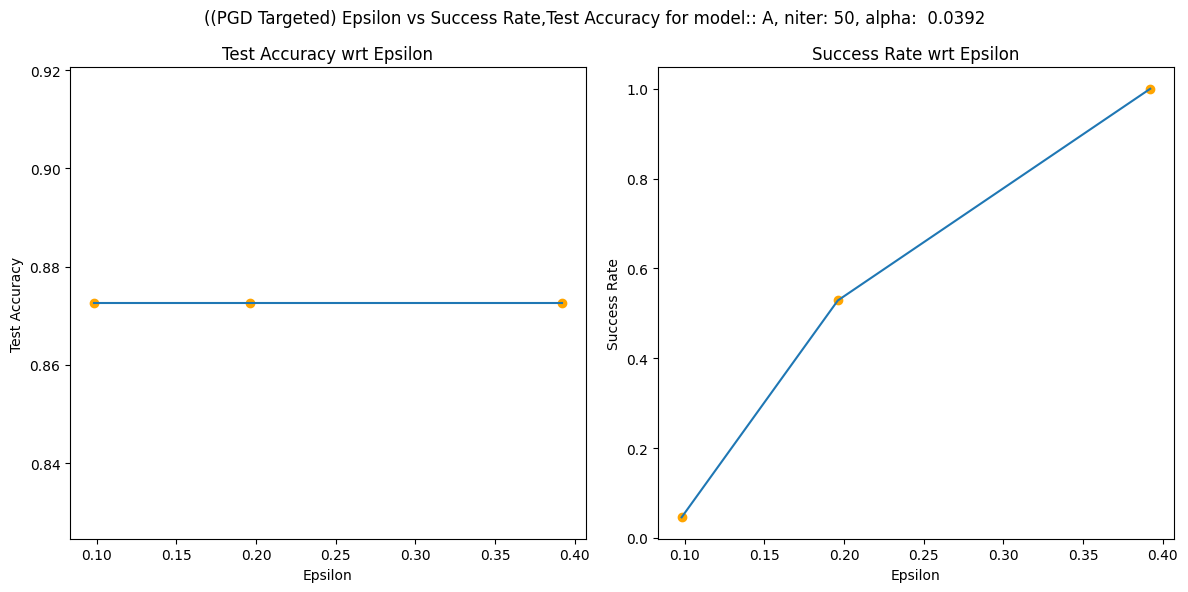

In [53]:
alpha = 10/255
n_iter = 50
model = modelA
epsilon_list = [25/255, 50/255,100/255]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []


for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model A, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis=0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted_attack(input_tensor, input_label, model, n_iter=n_iter, alpha=alpha, epsilon=epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)

    pred_adv_tensor = torch.cat(pred_adv, dim=0)
    adversarial_inputs_tensor = torch.cat(adversarial_inputs, dim=0)

    test_accuracy = test(model, adversarial_inputs_tensor, y_test, len(y_test))
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv_tensor]
    success_rate = targeted_attack_success(final_pred, y_test)
    
    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [test_accuracy]
    
    print(f'Success rate of the attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on clean inputs was: {model_A_ref_acc}')
    attack_plot(perturbed_images=adversarial_inputs_tensor, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model='A', n_iter=n_iter, alpha=alpha)
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='A', attack='(PGD Targeted)', n_iter=n_iter, alpha=alpha)

____________________________________________________________________
Model BV, epsilon: 0.09803921568627451, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


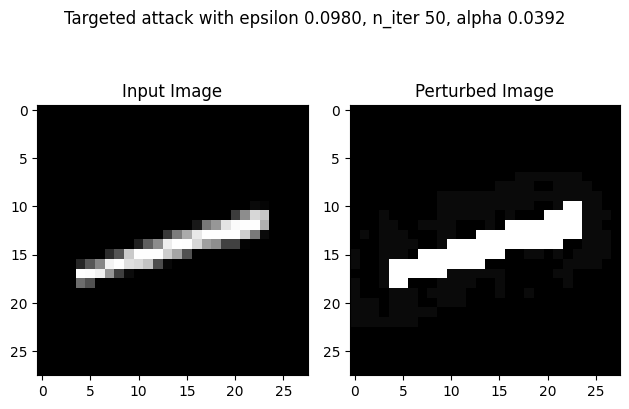

____________________________________________________________________
Model BV, epsilon: 0.19607843137254902, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


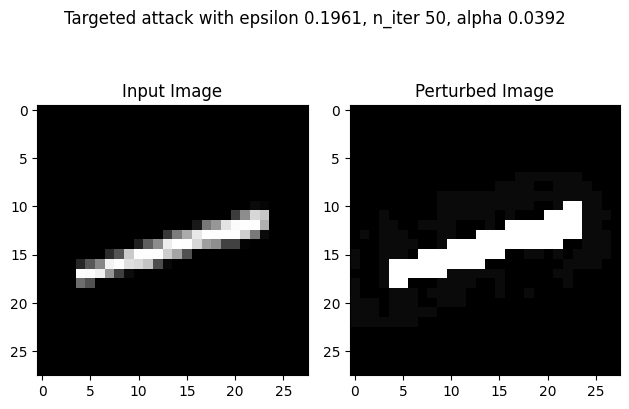

____________________________________________________________________
Model BV, epsilon: 0.39215686274509803, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


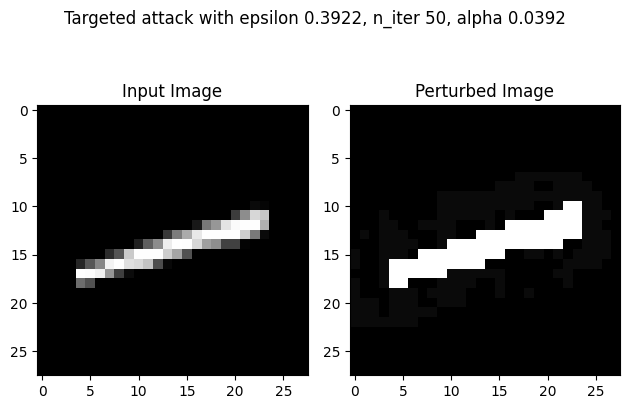

____________________________________________________________________
Model BV, epsilon: 0.49019607843137253, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


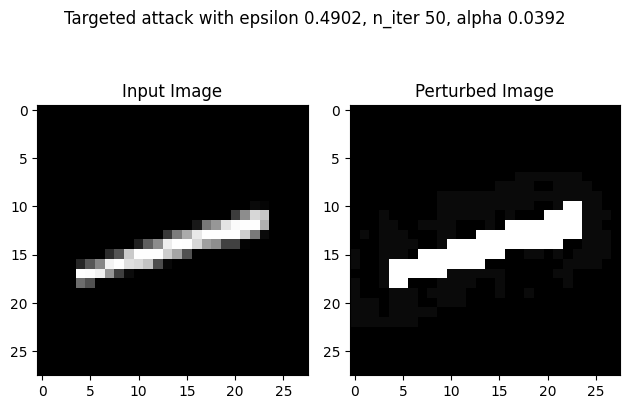

____________________________________________________________________
Model BV, epsilon: 0.5882352941176471, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


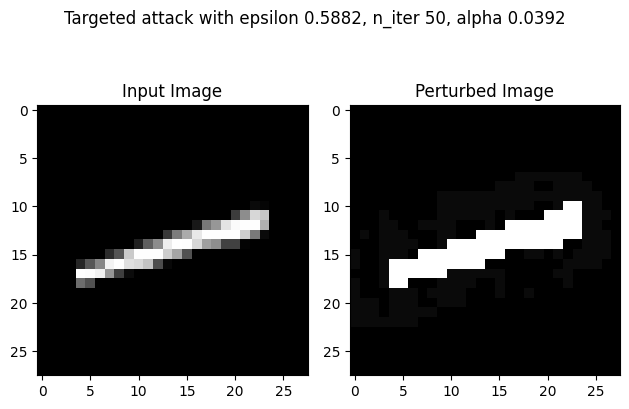

____________________________________________________________________
Model BV, epsilon: 0.7843137254901961, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


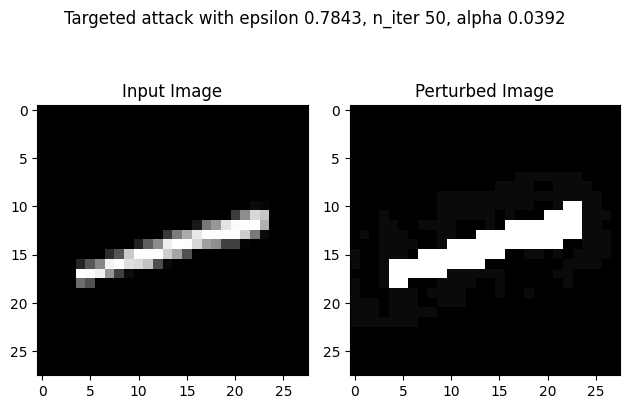

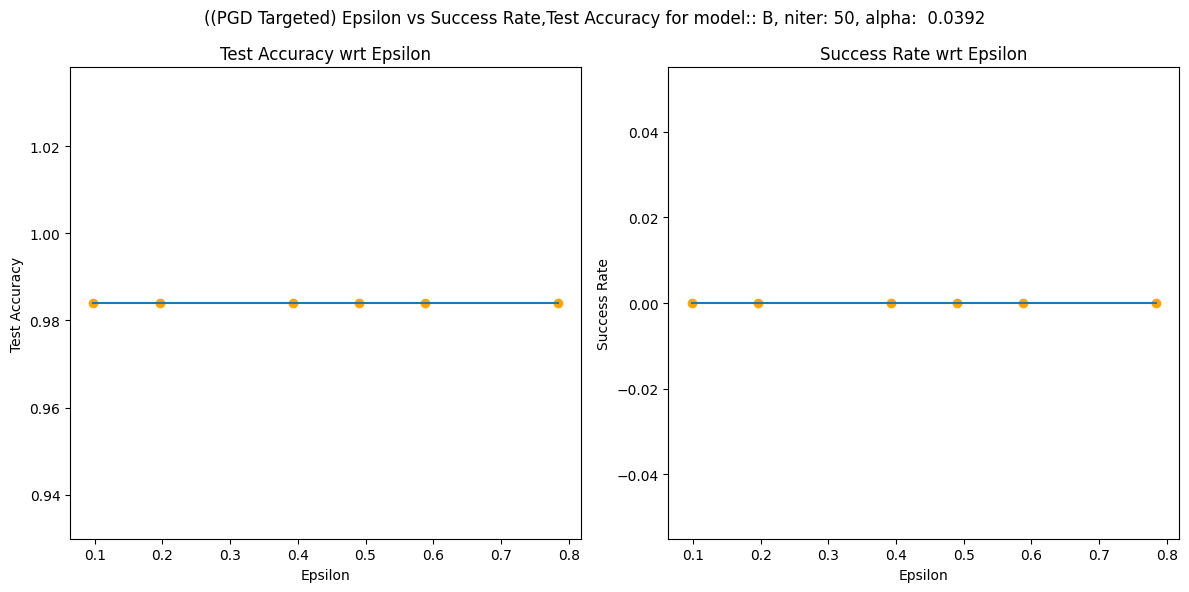

In [54]:
alpha = 10/255
n_iter = 50
model = modelB
epsilon_list = [25/255, 50/255,100/255, 125/255, 150/255, 200/255]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model BV, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis=0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted_attack(input_tensor, input_label, model, n_iter=n_iter, alpha=alpha, epsilon=epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)

    pred_adv_tensor = torch.cat(pred_adv, dim=0)
    adversarial_inputs_tensor = torch.cat(adversarial_inputs, dim=0)

    test_accuracy = test(model, adversarial_inputs_tensor, y_test, len(y_test))
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv_tensor]
    success_rate = targeted_attack_success(final_pred, y_test)

    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [test_accuracy]
    
    print(f'Success rate of the attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on clean inputs was: {model_A_ref_acc}')
    attack_plot(perturbed_images=adversarial_inputs_tensor, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model='B', n_iter=n_iter, alpha=alpha)
    
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='B', attack='(PGD Targeted)', n_iter=n_iter, alpha=alpha)

# Improved Targeted Attack
- Note that in the recitation we implemented adam optimizer for the targeted attack.
- In this case, we use PGD with Adam but we also add the following improvements
  - random start for the attack instead of fix start
  - LR Decay
  - Early Stopping
  - Adaptive Epsilon

In [65]:
norm = Normalize(mean=[0.485], std=[0.229]) # for one channel

In [72]:
def pgd_adam_improved(input, label, model, target_class=8, class_to_attack=1, n_iter=150, alpha=2/255, epsilon=16/255, decay_rate=0.25, early_stop_epsilon=1e-3, epsilon_scale_factor=1.2):
    if label != class_to_attack:
        predictions = model(norm(input))
        return input, predictions
    else:
        x = input.detach().clone()

        x = x + (torch.randn_like(x) * epsilon).clamp(-epsilon, epsilon)
        # this is the random startt 
        x = x.clamp(0, 1)

        m = torch.zeros_like(x)
        v = torch.zeros_like(x)

        best_loss = float('inf')
        for i in range(n_iter):
            x.requires_grad = True
            predictions = model(norm(x))
            model.zero_grad()
            loss = nn.CrossEntropyLoss()(predictions, torch.LongTensor([target_class]))
            loss.backward()
            gradient = x.grad

            t = i + 1
            m = 0.9 * m + (1 - 0.9) * gradient
            v = 0.999 * v + (1 - 0.999) * gradient.pow(2)
            m_hat = m / (1 - 0.9 ** t)
            v_hat = v / (1 - 0.999 ** t)
            corrected_grad = m_hat / (torch.sqrt(v_hat) + 1e-8)

            with torch.no_grad():
                x = x - alpha * corrected_grad.sign()
                eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
                x = torch.clamp(input + eta, min=0, max=1)
                x = torch.round(x * 255) / 255

            # Early stopping
            if best_loss - loss.item() < early_stop_epsilon:
                break
            best_loss = min(best_loss, loss.item())

            # LR decay
            alpha *= (1 / (1 + decay_rate * t))

            # Adaptive Epsilon Adjustment
            if i % 10 == 0 and i > 0: 
                epsilon *= epsilon_scale_factor

        prediction = model(norm(x))
        return x, prediction


____________________________________________________________________
Model A, epsilon: 0.09803921568627451, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8726
Success rate of the attack: 0.04229074889867841
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


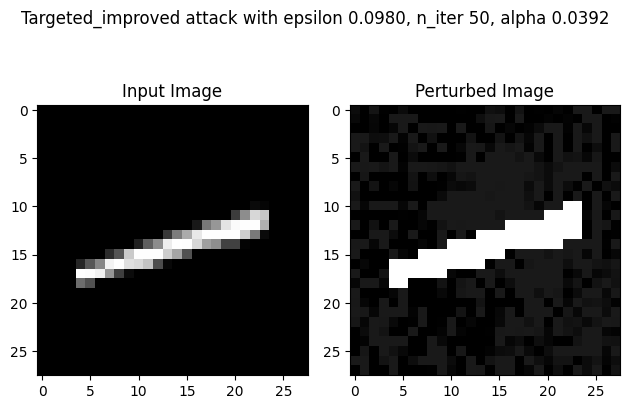

____________________________________________________________________
Model A, epsilon: 0.19607843137254902, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8726
Success rate of the attack: 0.1841409691629956
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


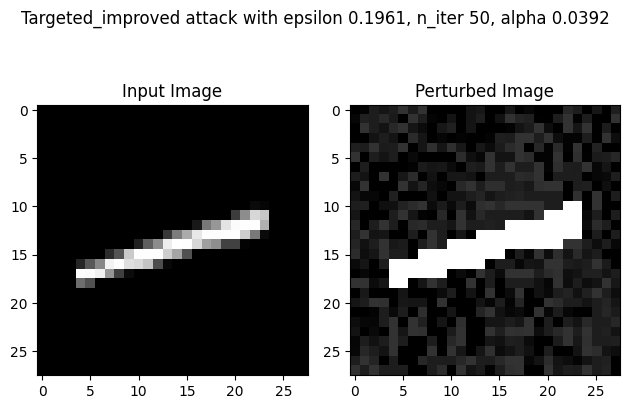

____________________________________________________________________
Model A, epsilon: 0.39215686274509803, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8726
Success rate of the attack: 0.44052863436123346
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


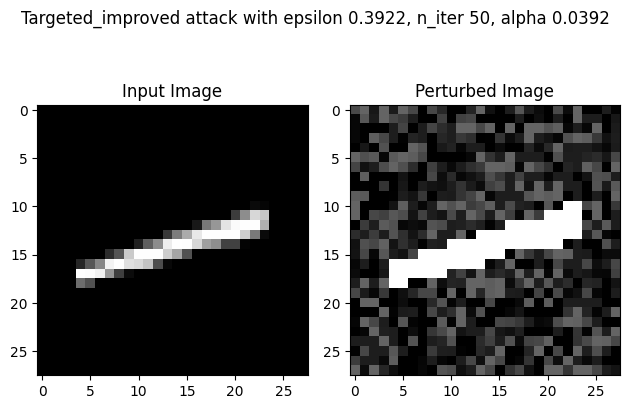

____________________________________________________________________
Model A, epsilon: 0.49019607843137253, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8726
Success rate of the attack: 0.5400881057268723
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


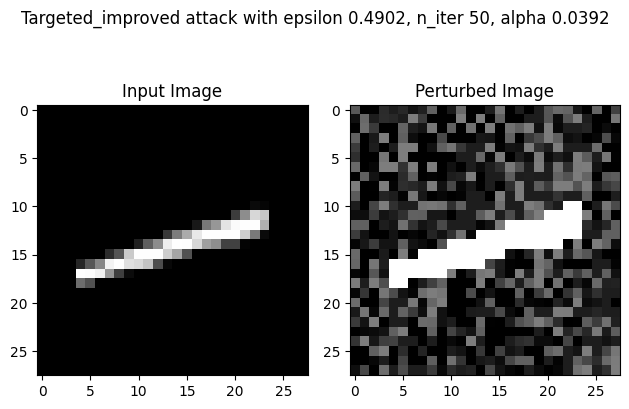

____________________________________________________________________
Model A, epsilon: 0.5882352941176471, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8726
Success rate of the attack: 0.5823788546255506
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


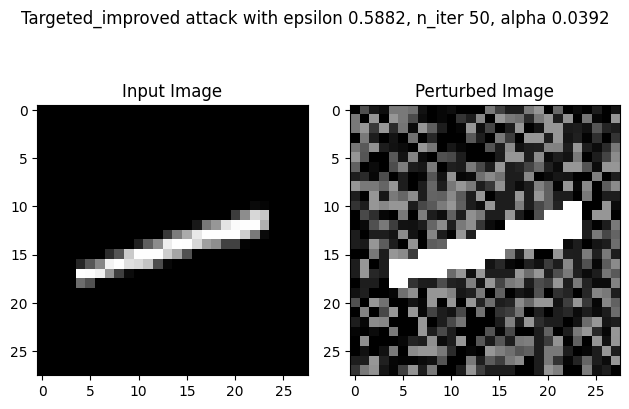

____________________________________________________________________
Model A, epsilon: 0.7843137254901961, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8726
Success rate of the attack: 0.6748898678414097
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


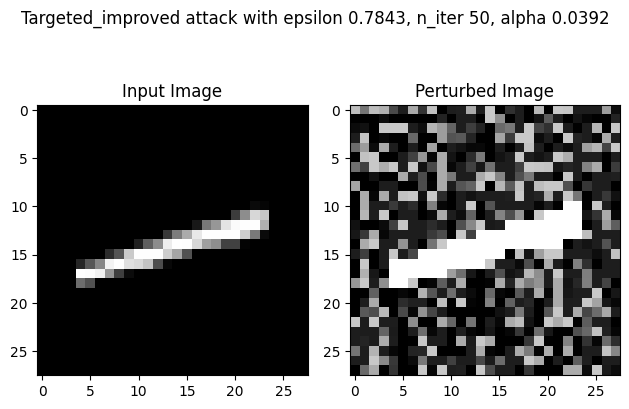

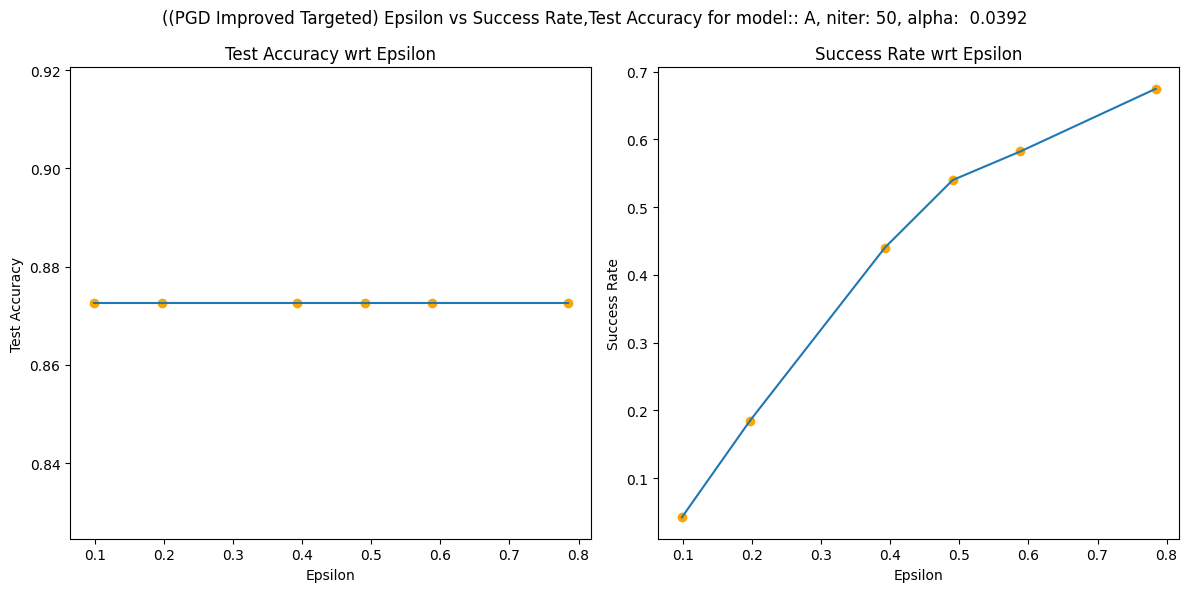

In [56]:
alpha = 10/255
n_iter = 50
model = modelA
epsilon_list = [25/255, 50/255,100/255, 125/255, 150/255, 200/255]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model A, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis=0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_adam_improved(input_tensor, input_label, model, n_iter=n_iter, alpha=alpha, epsilon=epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)

    pred_adv_tensor = torch.cat(pred_adv, dim=0)
    adversarial_inputs_tensor = torch.cat(adversarial_inputs, dim=0)

    test_accuracy = test(model, adversarial_inputs_tensor, y_test, len(y_test))
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv_tensor]
    success_rate = targeted_attack_success(final_pred, y_test)

    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [test_accuracy]
    
    print(f'Success rate of the attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on clean inputs was: {model_A_ref_acc}')
    attack_plot(perturbed_images=adversarial_inputs_tensor, test_images=x_test, index=2, name='Targeted_improved', epsilon=epsilon, model='A', n_iter=n_iter, alpha=alpha)
    
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='A', attack='(PGD Improved Targeted)', n_iter=n_iter, alpha=alpha)

____________________________________________________________________
Model B, epsilon: 0.09803921568627451, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


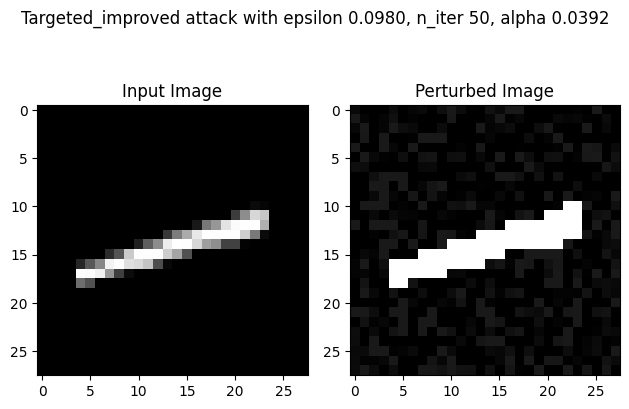

____________________________________________________________________
Model B, epsilon: 0.19607843137254902, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


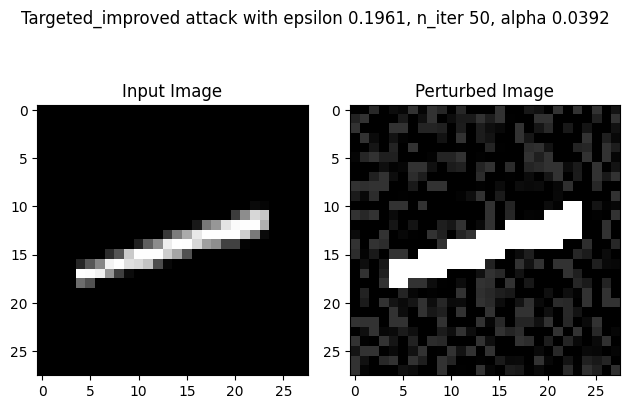

____________________________________________________________________
Model B, epsilon: 0.39215686274509803, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


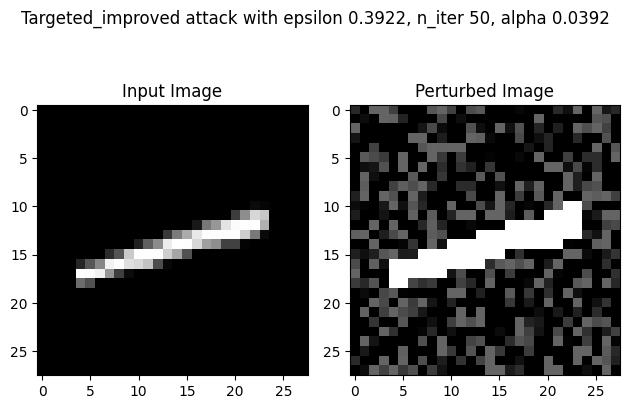

____________________________________________________________________
Model B, epsilon: 0.49019607843137253, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


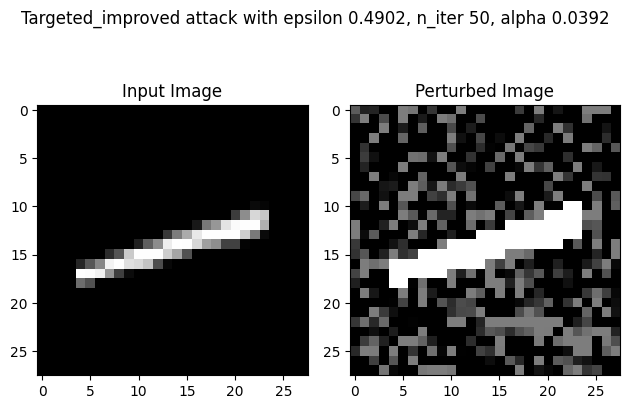

____________________________________________________________________
Model B, epsilon: 0.5882352941176471, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


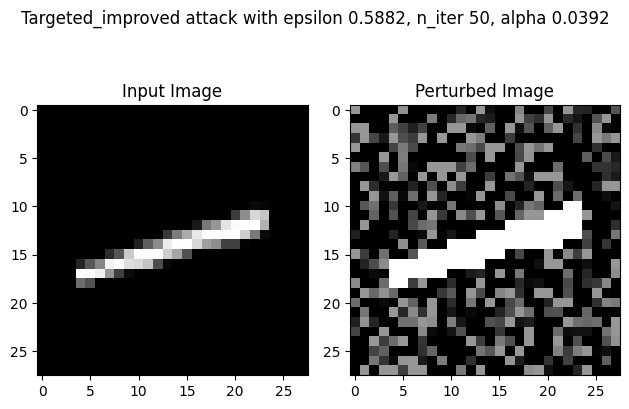

____________________________________________________________________
Model B, epsilon: 0.7843137254901961, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


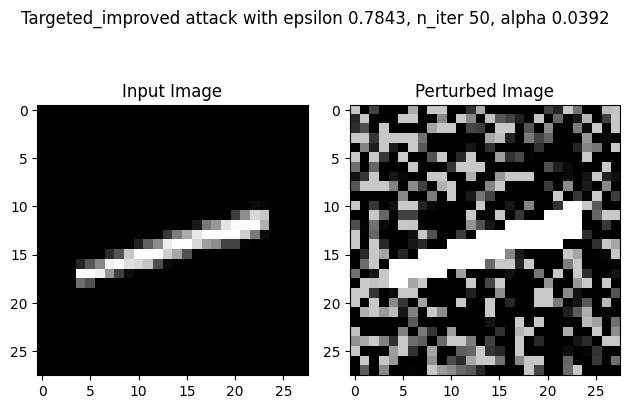

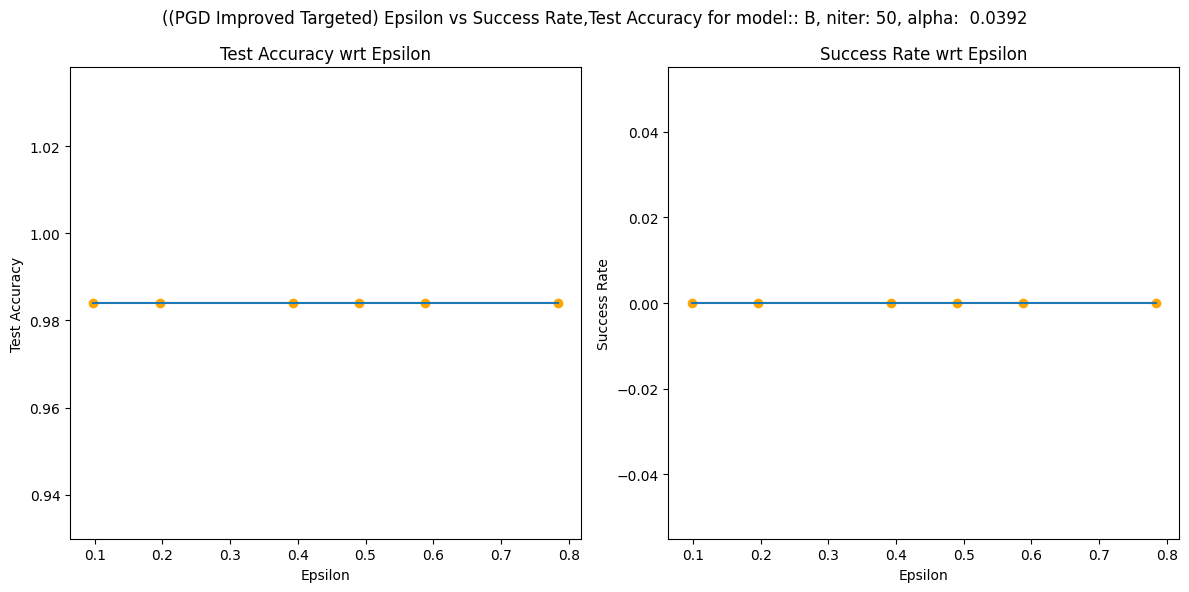

In [57]:
alpha = 10/255
n_iter = 50
model = modelB
epsilon_list = [25/255, 50/255,100/255, 125/255, 150/255, 200/255]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model B, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis=0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_adam_improved(input_tensor, input_label, model, n_iter=n_iter, alpha=alpha, epsilon=epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)

    pred_adv_tensor = torch.cat(pred_adv, dim=0)
    adversarial_inputs_tensor = torch.cat(adversarial_inputs, dim=0)

    test_accuracy = test(model, adversarial_inputs_tensor, y_test, len(y_test))
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv_tensor]
    success_rate = targeted_attack_success(final_pred, y_test)

    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [test_accuracy]
    
    print(f'Success rate of the attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on clean inputs was: {model_A_ref_acc}')
    attack_plot(perturbed_images=adversarial_inputs_tensor, test_images=x_test, index=2, name='Targeted_improved', epsilon=epsilon, model='A', n_iter=n_iter, alpha=alpha)
    
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='B', attack='(PGD Improved Targeted)', n_iter=n_iter, alpha=alpha)

# Bonus

In [67]:
norm = Normalize(mean=[0.485], std=[0.229]) # for one channel

____________________________________________________________________
Model A, epsilon: 0.03137254901960784, alpha: 0.19607843137254902, n_iter: 99


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8726
Success rate of the attack: 0.003524229074889868
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


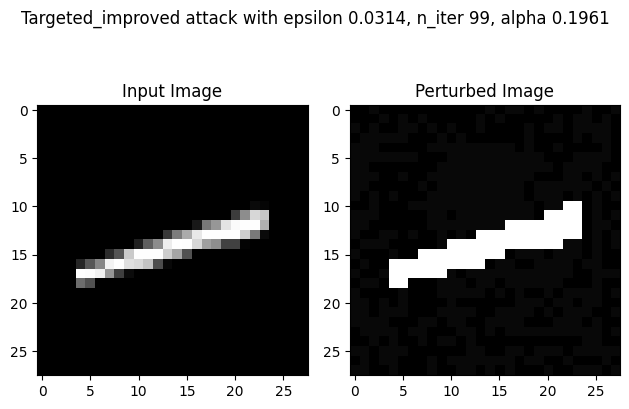

____________________________________________________________________
Model A, epsilon: 0.06274509803921569, alpha: 0.19607843137254902, n_iter: 99
accuracy: 0.8726
Success rate of the attack: 0.010572687224669603
Accuracy of the model on adversarial inputs: 0.8726
Accuracy of the model on clean inputs was: 0.9856


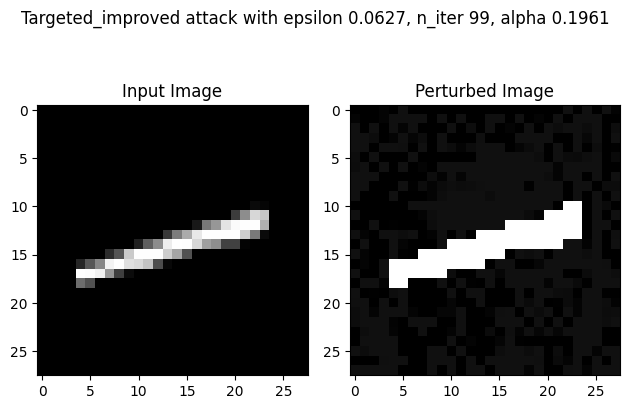

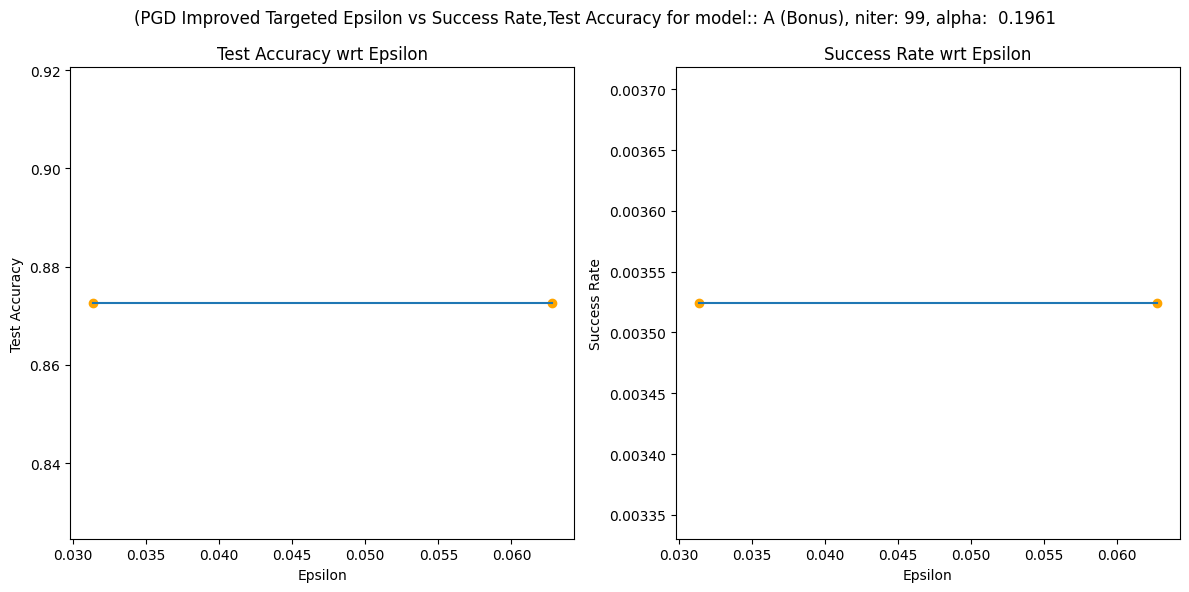

In [69]:
alpha = 50/255
n_iter = 99
model = modelA
epsilon_list = [8/255, 16/255]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model A, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis=0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_adam_improved(input_tensor, input_label, model, n_iter=n_iter, alpha=alpha, epsilon=epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)

    pred_adv_tensor = torch.cat(pred_adv, dim=0)
    adversarial_inputs_tensor = torch.cat(adversarial_inputs, dim=0)

    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [test_accuracy]
    
    test_accuracy = test(model, adversarial_inputs_tensor, y_test, len(y_test))
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv_tensor]
    success_rate = targeted_attack_success(final_pred, y_test)

    print(f'Success rate of the attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on clean inputs was: {model_A_ref_acc}')
    attack_plot(perturbed_images=adversarial_inputs_tensor, test_images=x_test, index=2, name='Targeted_improved', epsilon=epsilon, model='A (bonus)', n_iter=n_iter, alpha=alpha)
    
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='A (Bonus)', attack='PGD Improved Targeted', n_iter=n_iter, alpha=alpha)

____________________________________________________________________
Model B, epsilon: 0.03137254901960784, alpha: 0.19607843137254902, n_iter: 99


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_9090/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


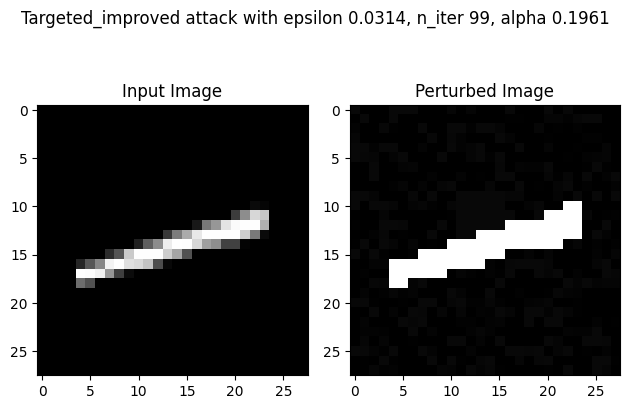

____________________________________________________________________
Model B, epsilon: 0.06274509803921569, alpha: 0.19607843137254902, n_iter: 99
accuracy: 0.984
Success rate of the attack: 0.0
Accuracy of the model on adversarial inputs: 0.984
Accuracy of the model on clean inputs was: 0.9856


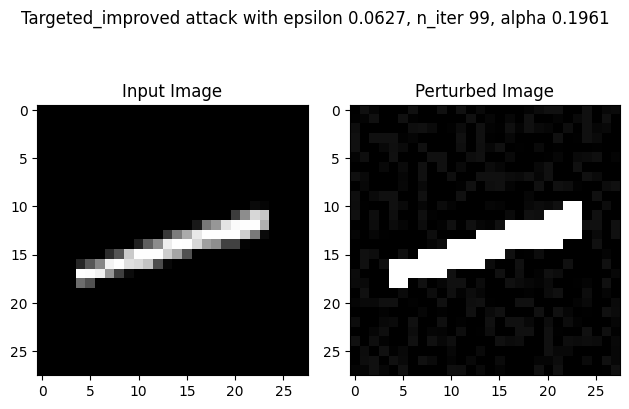

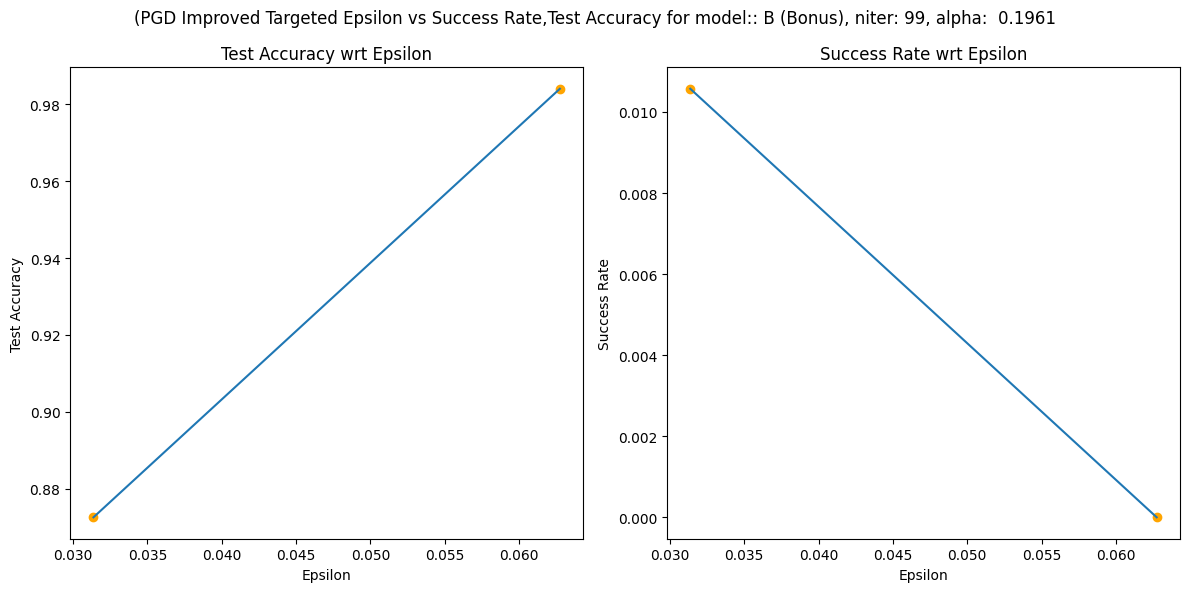

In [70]:
alpha = 50/255
n_iter = 99
model = modelB
epsilon_list = [8/255, 16/255]
epsilon_success_rate_list = []
epsilon_adv_acc_list = []

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model B, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis=0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_adam_improved(input_tensor, input_label, model, n_iter=n_iter, alpha=alpha, epsilon=epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)

    pred_adv_tensor = torch.cat(pred_adv, dim=0)
    adversarial_inputs_tensor = torch.cat(adversarial_inputs, dim=0)

    epsilon_success_rate_list += [success_rate]
    epsilon_adv_acc_list += [test_accuracy]
    
    test_accuracy = test(model, adversarial_inputs_tensor, y_test, len(y_test))
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv_tensor]
    success_rate = targeted_attack_success(final_pred, y_test)

    print(f'Success rate of the attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on clean inputs was: {model_A_ref_acc}')
    attack_plot(perturbed_images=adversarial_inputs_tensor, test_images=x_test, index=2, name='Targeted_improved', epsilon=epsilon, model='B (bonus)', n_iter=n_iter, alpha=alpha)
    
plot_success_rate(epsilon_list, epsilon_adv_acc_list, epsilon_success_rate_list, model='B (Bonus)', attack='PGD Improved Targeted', n_iter=n_iter, alpha=alpha)